## Part B:  Deep Learning for Image Data

*Markdown formats: All tables and images will be aligned to the left.

In [78]:
%%html
<style>table {float:left}</style>
<style>img {float:left}</style>

<hr style="height:1px;border:none;color:#333;background-color:#333;" />

**Task Description**

1. Organise the Denoising Autoencoder (DAE) project structure, get data and run the notebook.
2. Experiment with batch and epochs for model training.
3. Experiment with DAE optimisers and their parameters (e.g. SGD, RMSprop, Adam, Adamax, Nadam).
4. Change the DAE details / architecture
5. Report your experimental results.
6. Include performance results and charts for your experiment runs.

<hr style="height:1px;border:none;color:#333;background-color:#333;" />

## Table of Content
   
1. [Notebook Preparation](#cell_Preparation)

2. [Data Preprocessing](#cell_Preprocessing)

3. [Model Construction](#cell_model)

4. [Model Execution](#cell_execution)
 
5. [Experiments Report](#cell_report)



<a id = "cell_Preparation"></a>
## 1. Notebook Preparation

*Load all required Python libraries (e.g. pandas, tensorflow, keras).*

In [79]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import tensorflow as tf
import time

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Nadam, RMSprop, Adadelta
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Reshape, Activation
from tensorflow.keras.optimizers import Adam
from keras.layers.convolutional import Conv1D 
from keras.layers import LeakyReLU
from tensorflow.python.keras.layers import LayerNormalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from keras.layers import MaxPooling2D, MaxPooling1D
from keras.layers import UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.layers import Conv2DTranspose


In [81]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error


In [82]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [83]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

**Create a function to plot images.**

In [84]:
def plot_images(ims, xsize=6, ysize=6, cols=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        if (ims.shape[-1] != 3):
            ims = ims = ims[:,:,:,0]
    f = plt.figure(figsize=(xsize, ysize))
    rows=len(ims)//cols if len(ims) % cols == 0 else len(ims)//cols + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        plt.gray()

**Create a function to plot history.**

In [85]:
def plot_hist(h, xsize=6, ysize=5):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    
    # Get training and validation keys
    ks = list(h.keys())
    n2 = math.floor(len(ks)/2)
    train_keys = ks[0:n2]
    valid_keys = ks[n2:2*n2]
    
    # summarize history for different metrics
    for i in range(n2):
        plt.plot(h[train_keys[i]])
        plt.plot(h[valid_keys[i]])
        plt.title('Training vs Validation '+train_keys[i])
        plt.ylabel(train_keys[i])
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.draw()
        plt.show()
    
    return

**Calculates image to image errors:**

In [86]:
def rmse_images(images1, images2):
    return math.sqrt(np.square(np.subtract(images1, images2)).mean())

def mae_images(images1, images2):
    return np.abs(np.subtract(images1, images2)).mean()

<a id = "cell_Preprocessing"></a>
## 2. Data Preprocessing

*Load data from file and carry out necessary preprocessing. Prepare the data for training and validation. We are working with CIFAR10 images. Some code to load the data is provided below.*

In [87]:
from tensorflow.keras.datasets import cifar10

# Data parameters
img_rows, img_cols, img_ch = 32, 32, 3
input_shape = (img_rows, img_cols, img_ch)

num_classes = 10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# reshape images for processing

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, img_ch)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, img_ch)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print('Train shape: x=', x_train.shape, ', y=', y_train.shape)
print('Test shape: x=', x_test.shape, ', y=', y_test.shape)

Train shape: x= (50000, 32, 32, 3) , y= (50000, 10)
Test shape: x= (10000, 32, 32, 3) , y= (10000, 10)


*Inject noise into all images (both training and testing). with noice factor = 0.3*

In [88]:
#Introduce some noise in both training and test data sets
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

*Plot original "clean" images and noisy images.*

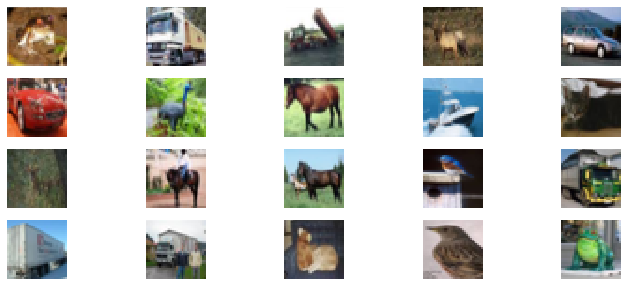

In [89]:
plot_images(x_train[0:20], cols=5, xsize=12, ysize=5)

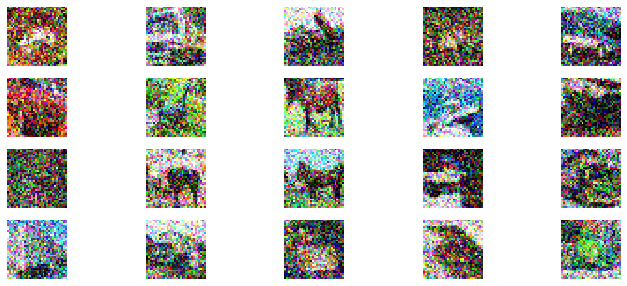

In [90]:
plot_images(x_train_noisy[0:20], cols=5, xsize=12, ysize=5)

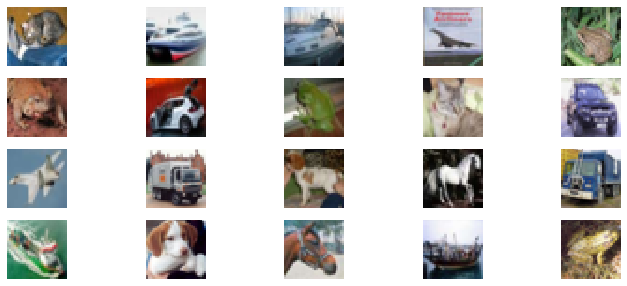

In [91]:
plot_images(x_test[0:20], cols=5, xsize=12, ysize=5)

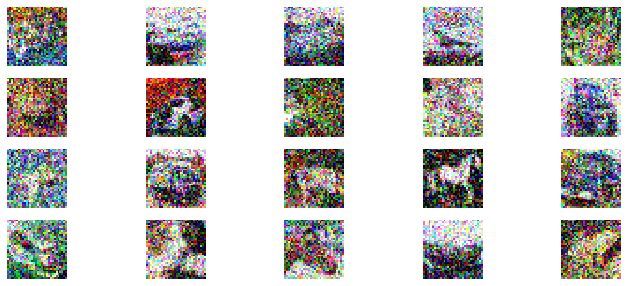

In [92]:
plot_images(x_test_noisy[0:20], cols=5, xsize=12, ysize=5)

<a id = "cell_model"></a>
## 3. Model Construction

*Provide code to create your denoising autoencoder in this section. 2  models with varied settings (e.g. layers, types of layer,  number of nodes, activation functions, optimizers).

**The model 1 is builded based on deep auencoders which consist of encoder and decoder.**

**In the part encoding, it consists of 32 hidden nodes with ReLU activation function, then use 16 hidden nodes for next layer**

**For decoding, it also contains 16 hidden nodes with ReLu activation funcstion as well, and then use 32 hidden nodes for next layers**

**Sigmoid activation function is used to define whether it has noise or not**

In [93]:
#Model 1
input_img1 = Input(shape=input_shape)

encoded = Dense(32, activation='relu')(input_img1)
#encoded = LeakyReLU(alpha=.001)(encoded)
encoded = Dense(16, activation='relu')(encoded)
#encoded = BatchNormalization(momentum=0.1)(encoded)
decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(decoded)
#decoded = LeakyReLU(alpha=.001)(decoded)
#decoded = Dropout(0.1)(encoded)
#decoded = BatchNormalization(momentum=0.1)(decoded)

decoded = Dense(3, activation='sigmoid')(decoded)

autoencoder1 = Model(input_img1, decoded)
autoencoder1.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
dense_11 (Dense)             (None, 32, 32, 32)        128       
_________________________________________________________________
dense_12 (Dense)             (None, 32, 32, 16)        528       
_________________________________________________________________
dense_13 (Dense)             (None, 32, 32, 16)        272       
_________________________________________________________________
dense_14 (Dense)             (None, 32, 32, 32)        544       
_________________________________________________________________
dense_15 (Dense)             (None, 32, 32, 3)         99        
Total params: 1,571
Trainable params: 1,571
Non-trainable params: 0
_________________________________________________________

*The model needs 1,571 params to build model.*

In [94]:
# With Adadelta optimizer for model 1
opt_adadelta = Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07)

**The model 2 is builded based on convolutional autoencoders.**

**Firstly, The econding with convolution consists of 16 filters with ReLU activation function. Then using LeakyReLU with alpha = 0.002 and applying MaxPooling2D**

**In part of decoding with convolution, using 64 filters deconding LeakyReLU with alpha = 0.002 before apply UpSampling2D in this part.**

**Sigmoid activation function is used to define whether it has noise or not**

In [95]:
#Model 2

input_img2 = Input(shape=input_shape)

x = Conv2D(16, (3, 3), padding='same')(input_img2) # activation='relu'
    #return_sequences=True,
    #kernel_initializer='normal',
    #kernel_regularizer=regularizers.l1_l2(0.01), 
    #bias_regularizer=regularizers.l1_l2(0.01)
# x = Dropout(0.1)(x)
# x = BatchNormalization()(x)
x = LeakyReLU(alpha=.002)(x)

encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), padding='same')(encoded)
# x = Dropout(0.0)(x)
# x = BatchNormalization()(x)
x = LeakyReLU(alpha=.002)(x)

x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder2 = Model(input_img2, decoded)
autoencoder2.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        9280      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 32, 32, 64)        0   

*The model needs 11,459 params to build model*

In [96]:
# With RMSprop optimizer for model 2
#opt_rmsprop = RMSprop(learning_rate=0.005, rho=0.95, momentum=0.01, epsilon=1e-07)
opt_nadam = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

<a id = "cell_execution"></a>
## 4. Model Execution

*This section is to provide code to fit the models. Denoise the images on the test sets and visualize the denoised images for both models. Calculate the MAE (between the original and denoised images) on the test sets to compare the performance of the two models.*<br>

**Model 1**

*Specify Keras callbacks which allow additional functionality while the model is being fitted. Using ***EarlyStopping*** to stops fitting when no improvement.*

In [97]:
callbacks1 = [TensorBoard(log_dir='/tmp/autoencoder/deep-1', histogram_freq=1, write_graph=True, write_images=True, 
               embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None,
               profile_batch = 100000000),
             EarlyStopping(monitor='val_loss', patience=30, verbose=0)]


In [98]:
# fit model
start1 = time.process_time()

autoencoder1.compile(optimizer=opt_adadelta, loss='binary_crossentropy')
hist1 = autoencoder1.fit(x_train_noisy, x_train,
                epochs=300,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=callbacks1)

time1 = time.process_time() - start1
#time of process of model 1
print("Time of process for model 1: ", time1)

Epoch 1/300
391/391 [==============================] - 5s 12ms/step - loss: 0.6950 - val_loss: 0.6951
Epoch 2/300
391/391 [==============================] - 4s 11ms/step - loss: 0.6949 - val_loss: 0.6949
Epoch 3/300
391/391 [==============================] - 4s 11ms/step - loss: 0.6947 - val_loss: 0.6947
Epoch 4/300
391/391 [==============================] - 4s 11ms/step - loss: 0.6945 - val_loss: 0.6945
Epoch 5/300
391/391 [==============================] - 4s 11ms/step - loss: 0.6943 - val_loss: 0.6943
Epoch 6/300
391/391 [==============================] - 4s 11ms/step - loss: 0.6941 - val_loss: 0.6941
Epoch 7/300
391/391 [==============================] - 4s 11ms/step - loss: 0.6938 - val_loss: 0.6938
Epoch 8/300
391/391 [==============================] - 4s 11ms/step - loss: 0.6936 - val_loss: 0.6936
Epoch 9/300
391/391 [==============================] - 4s 11ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 10/300
391/391 [==============================] - 4s 11ms/step - loss: 0.693

**The time processing of model 1 is 1662s with the final epoch is 300.**

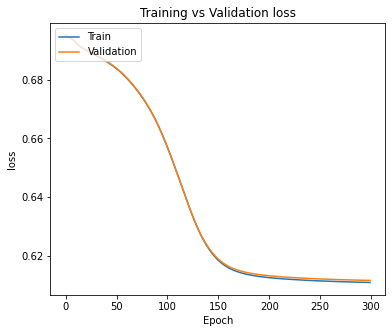

In [99]:
plot_hist(hist1.history, xsize=6, ysize=5)

***Since both curves stability decrease to a point so this is a good fit. Overall, the model was still improving although the progress was stalling at 300. This is perfectly normal in training process.***


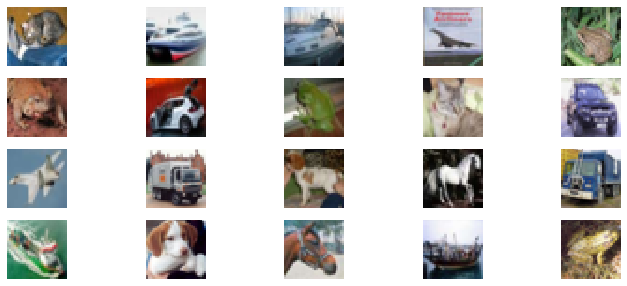

In [100]:
#Original images (test)
plot_images(x_test[0:20], cols=5, xsize=12, ysize=5)

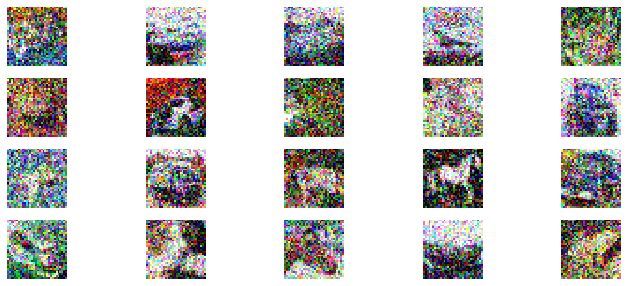

In [101]:
# test noisy
plot_images(x_test_noisy[0:20], cols=5, xsize=12, ysize=5)

In [102]:
# encode and decode some digits from the test set
decoded_noisy_imgs1 = autoencoder1.predict(x_test_noisy)

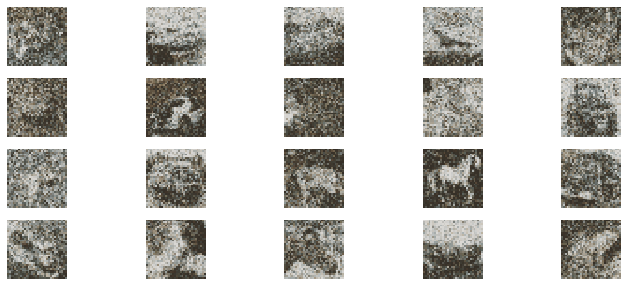

In [103]:
#Denoised images
plot_images(decoded_noisy_imgs1[0:20], cols=5, xsize=12, ysize=5)

In [104]:
print('Original vs noisy MAE =\t', round(mae_images(x_test, x_test_noisy), 5))
print('Original vs denoised MAE of model 1 =\t', round(mae_images(x_test, decoded_noisy_imgs1), 5))
print('Original vs denoised RMSE of model 1 =\t', round(rmse_images(x_test, decoded_noisy_imgs1), 5))

Original vs noisy MAE =	 0.20255
Original vs denoised MAE of model 1 =	 0.12766
Original vs denoised RMSE of model 1 =	 0.15892


**Model 2**

*Specify Keras callbacks which allow additional functionality while the model is being fitted. Using ***EarlyStopping*** to stops fitting when no improvement.*

In [105]:
callbacks2 = [TensorBoard(log_dir='/tmp/autoencoder/deep-4', histogram_freq=1, write_graph=True, write_images=True, 
               embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None,
               profile_batch = 100000000),
             EarlyStopping(monitor='val_loss', patience=30, verbose=0)]

In [106]:
# fit model
start2 = time.process_time()

autoencoder2.compile(optimizer=opt_nadam, loss='binary_crossentropy')
hist2 = autoencoder2.fit(x_train_noisy, x_train,
                epochs=300,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=callbacks2)

time2 = time.process_time() - start2
#time of process of model 2
print("Time of process for model 2: ", time2)

Epoch 1/300
391/391 [==============================] - 6s 13ms/step - loss: 0.5869 - val_loss: 0.5774
Epoch 2/300
391/391 [==============================] - 4s 11ms/step - loss: 0.5733 - val_loss: 0.5726
Epoch 3/300
391/391 [==============================] - 4s 11ms/step - loss: 0.5709 - val_loss: 0.5699
Epoch 4/300
391/391 [==============================] - 4s 11ms/step - loss: 0.5694 - val_loss: 0.5733
Epoch 5/300
391/391 [==============================] - 4s 11ms/step - loss: 0.5685 - val_loss: 0.5683
Epoch 6/300
391/391 [==============================] - 5s 12ms/step - loss: 0.5677 - val_loss: 0.5681
Epoch 7/300
391/391 [==============================] - 5s 12ms/step - loss: 0.5673 - val_loss: 0.5675
Epoch 8/300
391/391 [==============================] - 4s 11ms/step - loss: 0.5668 - val_loss: 0.5672
Epoch 9/300
391/391 [==============================] - 4s 11ms/step - loss: 0.5665 - val_loss: 0.5684
Epoch 10/300
391/391 [==============================] - 4s 11ms/step - loss: 0.566

**The time processing of model 2 is 1473s with the final epoch is 276.**

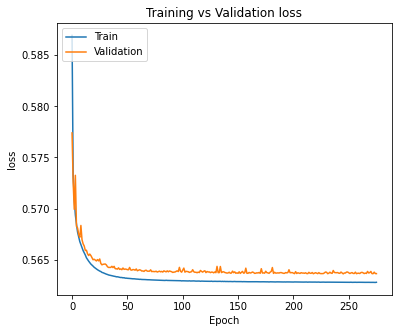

In [107]:
plot_hist(hist2.history, xsize=6, ysize=5)

**The figure shows that this is good model as both curves stability decrease to a point and there is not a big gap between two curves.**

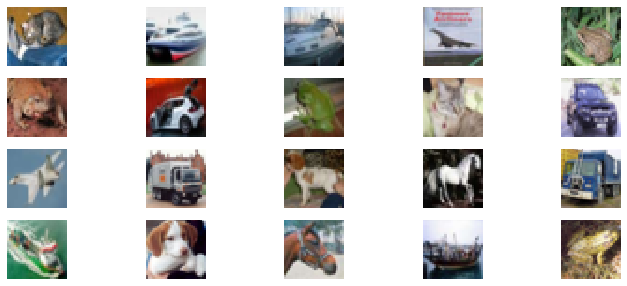

In [108]:
#Original images (test)
plot_images(x_test[0:20], cols=5, xsize=12, ysize=5)

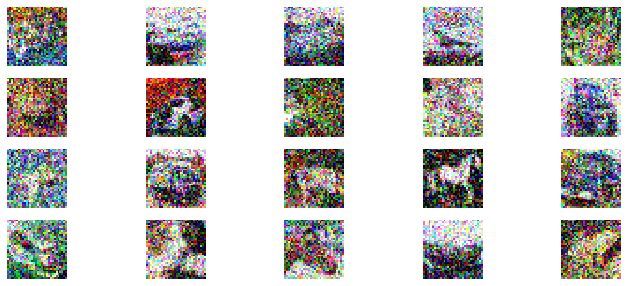

In [109]:
#test noisy
plot_images(x_test_noisy[0:20], cols=5, xsize=12, ysize=5)

In [110]:
# encode and decode some digits from the test set
decoded_noisy_imgs2 = autoencoder2.predict(x_test_noisy)

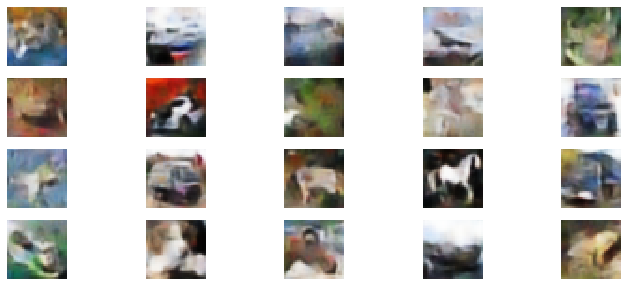

In [111]:
#Denoised images
plot_images(decoded_noisy_imgs2[0:20], cols=5, xsize=12, ysize=5)

In [112]:
print('Original vs noisy MAE =\t', round(mae_images(x_test, x_test_noisy), 5))
print('Original vs denoised MAE of model 2 =\t', round(mae_images(x_test, decoded_noisy_imgs2), 5))
print('Original vs denoised RMSE of model 2 =\t', round(rmse_images(x_test, decoded_noisy_imgs2), 5))

Original vs noisy MAE =	 0.20255
Original vs denoised MAE of model 2 =	 0.05841
Original vs denoised RMSE of model 2 =	 0.07693


<a id = "cell_report"></a>
## 5. Experiments Report

*In a paragraph discuss my results. Identify the strengths and weaknesses of the selected models. Which model would you recommend as a final solution? and why?.*
<br>

*Summary of experimental results in the table below.*


| Model# |  MAE | RMSE | Time(s) | Params | 
| :-: | -: | -: |-: |-: |
| 1 | 0.12979  | 0.16031| 1662.5426166930001  | 1,571 |  |
| 2 | 0.05841  | 0.07693| 1472.9305467270005  | 11,459 |  |


<br>

MAE and RMSE is used to measure accuracy of models. More precisely, these values are lower 
which also means a good model. From table of MAE summary, all models are quite good (from 0.058 to 0.16)

It can be seen that the accuracy of model 2 is higher than model 1 (0.058 compared to 0.13 and 0.077 compared to 0.16).

Although the params needs for model 2 is nearly double model 1 (11,459 and 1,571) but the time processing of model 2 is lower than that of model 1 (1472s and 1662s).



Therefore, the strength of model 2 is high accuracy and fast while model 1 is does not cost.

The plot of training and validation loss to evaluate the performane of model. To be more specific, the model 1 shows that the model is very good fit. Meanwhile, the model 2 is quite good fit.

Overall, the model 2 should be used to remove noise from low resolution photograph because it is high accuracy and fast. However, we can consider the increase of the epoch in the model 1 (500) to observe whether the MAE in this model can be improved or not. Then, we can change to use this model, but need to consider the color removal of this model.